In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import math

In [2]:
mitbih = pd.read_csv("mitbih_test.csv")
mitbih_train = pd.read_csv("mitbih_train.csv")

In [3]:
data = mitbih_train.iloc[:, :186].values
labels = mitbih_train.iloc[:, 187].values

In [4]:
from keras.utils import to_categorical

one_hot_labels = np.zeros((len(labels), 5))
one_hot_labels[:] = to_categorical(labels[:], num_classes = 5)

Using TensorFlow backend.


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, one_hot_labels, test_size = 0.33, random_state = 42)

In [6]:
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, BatchNormalization, Dropout, Convolution1D, MaxPooling1D, SeparableConv1D, Flatten, MaxPool1D
from keras.optimizers import Adam
from keras.models import Model

#X_train[:] = add_gaussian_noise(X_train[:])#Small data augmentation
#X_test[:] = add_gaussian_noise(X_test[:])#Small data augmentation

X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

im_shape=(X_train.shape[1],1)
inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
conv1_1=BatchNormalization()(conv1_1)
pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
conv2_1=BatchNormalization()(conv2_1)
pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
conv3_1=BatchNormalization()(conv3_1)
pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
flatten=Flatten()(pool3)
dense_end1 = Dense(64, activation='relu')(flatten)
dense_end2 = Dense(32, activation='relu')(dense_end1)
main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)


model = Model(inputs= inputs_cnn, outputs=main_output)

In [7]:
model.compile(optimizer = Adam(lr = 100e-5),
              loss = "categorical_crossentropy",
              metrics = ['accuracy'])

In [8]:
EPOCHS = 5
history = model.fit(X_train, y_train, validation_split = 0.2, epochs = EPOCHS, shuffle = True, class_weight = 'auto')

Train on 46928 samples, validate on 11732 samples
Epoch 1/5
46928/46928 [==============================] - 45s 952us/step - loss: 0.1468 - accuracy: 0.9594 - val_loss: 0.1163 - val_accuracy: 0.9689
Epoch 2/5
46928/46928 [==============================] - 44s 934us/step - loss: 0.0844 - accuracy: 0.9759 - val_loss: 0.1207 - val_accuracy: 0.9633
Epoch 3/5
46928/46928 [==============================] - 45s 955us/step - loss: 0.0650 - accuracy: 0.9805 - val_loss: 0.1061 - val_accuracy: 0.9714
Epoch 4/5
46928/46928 [==============================] - 43s 910us/step - loss: 0.0546 - accuracy: 0.9837 - val_loss: 0.0674 - val_accuracy: 0.9807
Epoch 5/5
46928/46928 [==============================] - 46s 974us/step - loss: 0.0494 - accuracy: 0.9849 - val_loss: 0.0766 - val_accuracy: 0.9784


In [9]:
print(model.evaluate(X_test, y_test))

28893/28893 [==============================] - 8s 266us/step
[0.0733519502025894, 0.9793375730514526]


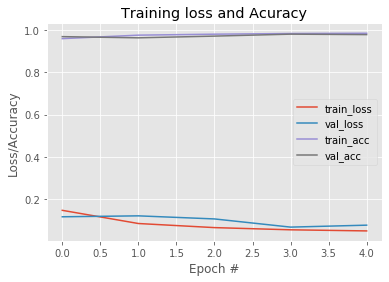

In [10]:
N = np.arange(0, EPOCHS)
title = "Training loss and Acuracy"

plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label = "train_loss")
plt.plot(N, history.history["val_loss"], label = "val_loss")
plt.plot(N, history.history["accuracy"], label = "train_acc")
plt.plot(N, history.history["val_accuracy"], label = "val_acc")
plt.title(title)
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [11]:
model_final = Model(inputs=model.input, outputs=model.layers[-2].output)
model_final.compile(optimizer = Adam(lr = 100e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:
representations = []

dataSVM = np.array(data.copy())

dataSVM = dataSVM.reshape(len(dataSVM), dataSVM.shape[1],1)

print(dataSVM.shape)
for i in range(len(mitbih_train)):
    representations.append(model_final.predict(np.array([dataSVM[i]])))
    

(87553, 186, 1)


In [14]:
representations = np.array(representations).squeeze()

In [15]:
print(representations.shape)
print(one_hot_labels.shape)
print(one_hot_labels)

(87553, 32)
(87553, 5)
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [16]:
X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM = train_test_split(representations, one_hot_labels, test_size = 0.33, random_state = 42)

In [19]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

clf = OneVsRestClassifier(LinearSVC(dual=False))

clf.fit(X_train_SVM, y_train_SVM)

y_pred = clf.decision_function(X_test_SVM)

rectified_prediction = np.where(y_pred < 0.5, 0, 1)

In [20]:
#print(y_pred)
print(rectified_prediction)
print("------------------")
print(y_test_SVM)

[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 ...
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
------------------
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [24]:
import sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

print("Accuracy: {0:.2f}".format(100 * accuracy_score(y_test_SVM, rectified_prediction)))
print("Precision: {0:.2f}".format(100 * precision_score(y_test_SVM, rectified_prediction, average='micro')))
print("F1 score: {0:.2f}".format(100 * f1_score(y_test_SVM, rectified_prediction, average='micro')))


Accuracy: 95.99
Precision: 99.13
F1 score: 97.54
